In [1]:
import itertools
import math
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Cnet(object):
    """
    Object that defines a concept network
    """
    
    def __init__(self,ini_pool=10,c=3,i=.5,b=.5,threshold=.9):
        """
        Initializes concept network
        """
        self.ini_pool=ini_pool #number of initial concepts
        self.c=int(c) #number of concepts used in a new concept generation
        self.i=float(i) #inheritance of fitness from predecessors
        self.b=float(threshold)#float(b)  #behavior parameter 1=seek refinement, 0=seek fitness
        self.threshold=float(threshold) #selection threshold - 1.0=very selective, 0.0=not selective
        self.n_nodes=0 #number of nodes
        self.t=0 #count time
        
        self.scores=[] #list of node scores to be used in the attachement kernel
        self.fitnesses=[] #list of fitnesses for diagnostics
        self.depths=[] #list of scores for diagnostics
        self.n_by_d={}
        
        self.g=self.init_network() #initialize the network
        self.t+=1
        
        
        
        
    def init_network(self):
        """
        Initialized the network
        """
        g=nx.DiGraph()
        
        for n in xrange(self.ini_pool):
            #f=np.random.uniform(0,1,1)[0] #f=node fitness
            f=np.random.normal(.5,self.i,1)[0]
            if f>1.0:
                f=1.0
            elif f<0.0:
                f=0.0
            d=1 #d=node depth, 
            score=d**self.b*f**(1.0-self.b) #get score for node
            
            g.add_node(n,d=d,f=f,s=score,
                       t=int(self.t),
                       c=int(self.c),
                       i=float(self.i),
                       b=float(self.b),
                       threshold=float(self.threshold)) #add node to graph
            #print n
            self.n_by_d.setdefault(d,[]).append(n) #save node and depth
            self.scores.append(score) #append score
            self.fitnesses.append(f) #append fitness
            self.depths.append(d) #append depths
            self.n_nodes+=1 #increment number of nodes
        
        return g
    
    def gen_node(self,c=None):
        """
        Add a node the network
        """
        if c==None:
            c=self.c
        
        s_list=[]
        max_d=max(self.depths)
        for n,d in self.g.nodes(data=True):
            norm_d=d['d']/float(max_d)
            norm_f=d['f']
            n_score=norm_d**self.b*norm_f**(1.0-self.b)
            s_list.append(n_score)
        
        
        s_array=np.asarray(s_list)
        #print s_array
        max_score=max(s_list)
        cutoff=max_score*self.threshold
        #print cutoff
        bad_index=s_array<cutoff
        good_index=s_array>=cutoff
        s_array[bad_index]=0.0
        #s_array[good_index]=1.0
        #print s_array
            
        s_norm=[float(i)/sum(s_array) for i in s_array] #normalize scores to get probability of attachment
        #print s_norm
        #number of precedents
        num_preds=int(math.ceil(sum(good_index)*(1.0-self.threshold)))
        
        #if sum(good_index)<c:
            #preds=np.random.choice(self.g.nodes(),sum(good_index),replace=False,p=s_norm)
        #else:
            #preds=np.random.choice(self.g.nodes(),c,replace=False,p=s_norm) #chose predecessors of new node
        #print preds
        
        preds=np.random.choice(self.g.nodes(),num_preds,replace=False,p=s_norm) #chose predecessors of new node
        
        pred_fits=[]
        pred_depths=[]
        for n in preds: #get predecessor node information
            pred_fits.append(self.g.node[n]['f']) #fitness
            pred_depths.append(self.g.node[n]['d']) #depth
        d=np.random.choice(pred_depths,1)[0]+1 
        #print pred_depths,d
        #d=max(pred_depths)+1 #increase depth by 1
        #f=np.random.uniform(0,1,1)[0]*(1.0-self.i)+self.i*np.mean(pred_fits) #random fitness + inheritance
        f=np.random.normal(np.mean(pred_fits),self.i,1)[0]
        if f>1.0:
            f=1.0
        elif f<0.0:
            f=0.0
            
        score=d**self.b*f**(1.0-self.b) #get score for node
        
        
        n=int(self.n_nodes)
        
        self.g.add_node(n,d=d,f=f,s=score,
                        t=int(self.t),
                        c=int(self.c),
                        i=float(self.i),
                        b=float(self.b),
                        threshold=float(self.threshold)) #add node to graph) #add node to graph
        for pred in preds: #add edges
            self.g.add_edge(pred,n)
        
        self.n_by_d.setdefault(d,[]).append(n) #save node and depth
        self.scores.append(score) #append score
        self.fitnesses.append(f) #append fitness
        self.depths.append(d) #append depths
        self.n_nodes+=1 #increment number of nodes
        self.t+=1
        
        
    def test_graph(self,num_test,increments):
        num_removed=self.g.number_of_nodes()/increments
        
        data={}
        
        for i in xrange(num_test):
            g=self.g.copy()
            
            #analyze before removal
            rooted_nodes=set()
            for n in xrange(self.ini_pool):
                rooted_nodes.update(dfs_tree(g,n).nodes())
            rooted_nodes=list(rooted_nodes)
            
            #size
            s_0=len(rooted_nodes)
            
            #max depth
            max_d_0 = max([g.node[n]['d'] for n in rooted_nodes])
            max_d_nodes=[n for n in g.nodes() if g.node[n]['d']==max_d_0]
            
            #max fitness
            max_f_0 = max([g.node[n]['f'] for n in max_d_nodes])
            
            #add params
            data.setdefault('r',[]).append(i)
            data.setdefault('b',[]).append(self.b)
            data.setdefault('c',[]).append(self.c)
            data.setdefault('i',[]).append(self.i)
            data.setdefault('threshold',[]).append(self.threshold)
            data.setdefault('o',[]).append(g.number_of_nodes())
            
            #add data
            data.setdefault('size',[]).append(float(s_0)/s_0)
            data.setdefault('max_d',[]).append(float(max_d_0)/max_d_0)
            data.setdefault('max_f',[]).append(float(max_f_0)/1.0)
            
                
            for inc in xrange(increments):
                #get removed nodes
                nodes_removed=np.random.choice(g.nodes(),num_removed,replace=False)
                
                #remove nodes
                g.remove_nodes_from(nodes_removed)
                
                #Get data
                #Check roots
                rooted_nodes=set()
                for n in xrange(self.ini_pool):
                    if n in g.nodes():
                        rooted_nodes.update(dfs_tree(g,n).nodes())
                rooted_nodes=list(rooted_nodes)

                #size
                s=len(rooted_nodes)
                
                if s:
                    #max depth
                    max_d = max([g.node[n]['d'] for n in rooted_nodes])
                    max_d_nodes=[n for n in g.nodes() if g.node[n]['d']==max_d]

                    #max fitness
                    max_f = max([g.node[n]['f'] for n in max_d_nodes])
                else:
                    max_d=0
                    max_f=0.0

                #add params
                data.setdefault('r',[]).append(i)
                data.setdefault('b',[]).append(self.b)
                data.setdefault('c',[]).append(self.c)
                data.setdefault('i',[]).append(self.i)
                data.setdefault('threshold',[]).append(self.threshold)
                data.setdefault('o',[]).append(g.number_of_nodes())

                #add data
                data.setdefault('size',[]).append(float(s)/s_0)
                data.setdefault('max_d',[]).append(float(max_d)/max_d_0)
                data.setdefault('max_f',[]).append(float(max_f)/1.0)
                
        return data
                
        
    def test_graph_norm(self,num_test,occ_inc):
        size_max=self.g.number_of_nodes()
        num_removed=int(math.floor(size_max*occ_inc))
        increments=int(1.0/occ_inc)
        
        data={}
        
        for i in xrange(num_test):
            g=self.g.copy()
            
            #analyze before removal
            rooted_nodes=set()
            for n in xrange(self.ini_pool):
                rooted_nodes.update(dfs_tree(g,n).nodes())
            rooted_nodes=list(rooted_nodes)
            
            #size
            s_0=len(rooted_nodes)
            
            #max depth
            max_d_0 = max([g.node[n]['d'] for n in rooted_nodes])
            max_d_nodes=[n for n in g.nodes() if g.node[n]['d']==max_d_0]
            
            #max fitness
            max_f_0 = max([g.node[n]['f'] for n in max_d_nodes])
            
            #add params
            data.setdefault('r',[]).append(i)
            data.setdefault('b',[]).append(self.b)
            data.setdefault('c',[]).append(self.c)
            data.setdefault('i',[]).append(self.i)
            data.setdefault('threshold',[]).append(self.threshold)
            data.setdefault('o',[]).append(1.0)
            
            #add data
            data.setdefault('size',[]).append(float(s_0)/s_0)
            data.setdefault('max_d',[]).append(float(max_d_0)/max_d_0)
            data.setdefault('max_f',[]).append(float(max_f_0)/1.0)
            
                
            for inc in xrange(increments):
                #get removed nodes
                nodes_removed=np.random.choice(g.nodes(),num_removed,replace=False)
                
                #remove nodes
                g.remove_nodes_from(nodes_removed)
                
                #Get data
                #Check roots
                rooted_nodes=set()
                for n in xrange(self.ini_pool):
                    if n in g.nodes():
                        rooted_nodes.update(dfs_tree(g,n).nodes())
                rooted_nodes=list(rooted_nodes)

                #size
                s=len(rooted_nodes)
                
                if s:
                    #max depth
                    max_d = max([g.node[n]['d'] for n in rooted_nodes])
                    max_d_nodes=[n for n in g.nodes() if g.node[n]['d']==max_d]

                    #max fitness
                    max_f = max([g.node[n]['f'] for n in max_d_nodes])
                else:
                    max_d=0
                    max_f=0.0

                #add params
                data.setdefault('r',[]).append(i)
                data.setdefault('b',[]).append(self.b)
                data.setdefault('c',[]).append(self.c)
                data.setdefault('i',[]).append(self.i)
                data.setdefault('threshold',[]).append(self.threshold)
                #data.setdefault('o',[]).append(g.number_of_nodes()/float(size_max))
                data.setdefault('o',[]).append(float(increments-(inc+1))/increments)

                #add data
                data.setdefault('size',[]).append(float(s)/s_0)
                data.setdefault('max_d',[]).append(float(max_d)/max_d_0)
                data.setdefault('max_f',[]).append(float(max_f)/1.0)
                
        return data

In [3]:
def func(graph):
    data={}
    data['node']=[x[0] for x in graph.nodes(data=True)]
    other_cols = graph.node[0].keys()
    for key in other_cols:
        data[key] = [x[1][key] for x in graph.nodes(data='True')]
    return data

In [8]:
graphs=[]
dfs=[]
removal_dfs=[]

pool=10
process_size_factor=10
num_process=30
c_list=[1]
#c_list=[1,3,5]
#i_list=[0.3,0.6,0.9]
i_list=[0.01,0.1,.3]
#t_list=[.2,.8]
t_list=[.2,.4,.6,.8]
#t_list=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
#i_list=[0.0,0.3,0.6,0.9]
#c_list=[1,3,5,7]
#beta_list=[0.0,0.2,0.4,0.6,0.8,1.0]
beta_list=[0.5]
for beta in beta_list:
    for c in c_list:
        for i in i_list:
            for t in t_list:
                print 'b={}, c={}, i={}, t={}'.format(beta,c,i,t)

                for inc in xrange(num_process):

                    g=Cnet(ini_pool=pool,c=c,i=i,b=beta,threshold=t) #behavior parameter 1=seek refinement, 0=seek fitness
                    while max(g.depths)<process_size_factor:
                    #while g.n_nodes<pool*process_size_factor:
                        g.gen_node()

                    graphs.append(g.g.copy())
                    dfs.append(pd.DataFrame(func(g.g)))
                    removal_dfs.append(pd.DataFrame(g.test_graph_norm(num_test=20,occ_inc=.05)))
                    #removal_dfs.append(pd.DataFrame(g.test_graph(num_test=5,increments=10)))

    #plt.figure()
    #plt.hist(g.fitnesses)
    #plt.title('Fitness Historgram, <f>={}, max(f)={}'.format(np.mean(g.fitnesses),max(g.fitnesses)))

    #plt.figure()
    #plt.hist(g.depths)
    #plt.title('Depth Historgram, <d>={}, max(d)={}'.format(np.mean(g.depths),max(g.depths)))

#for n,d in g.g.nodes(data=True):
    #print n,d,'in={}, out={}'.format(g.g.in_degree(n),g.g.out_degree(n))

#print g.n_nodes
#for d,ns in g.n_by_d.iteritems():
    #print d, len(ns)


#print graphs

removal_df=pd.concat(removal_dfs)
#print removal_df.head(50)

df=pd.concat(dfs)
#print df.head()

#plt.scatter(g.depths,g.fitnesses)

b=0.5, c=1, i=0.01, t=0.2
b=0.5, c=1, i=0.01, t=0.4
b=0.5, c=1, i=0.01, t=0.6
b=0.5, c=1, i=0.01, t=0.8
b=0.5, c=1, i=0.1, t=0.2
b=0.5, c=1, i=0.1, t=0.4
b=0.5, c=1, i=0.1, t=0.6
b=0.5, c=1, i=0.1, t=0.8
b=0.5, c=1, i=0.3, t=0.2
b=0.5, c=1, i=0.3, t=0.4
b=0.5, c=1, i=0.3, t=0.6
b=0.5, c=1, i=0.3, t=0.8


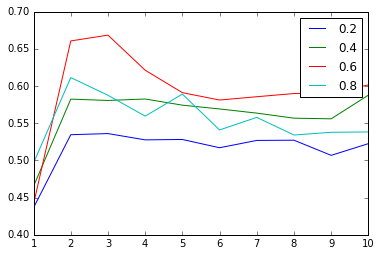

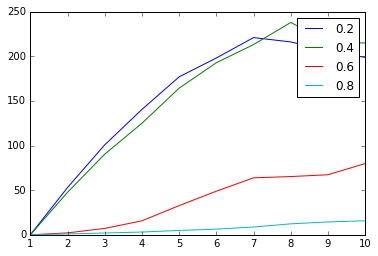

In [43]:

plt.figure()
d_n=df.d.unique()
for beta in df.threshold.unique():
    #print beta
    a_f=[]
    for i in df.d.unique():
        #print i*slice_size
        a_f.append(df.loc[(df['d']==i) & (df['threshold']==beta)].mean()['f'])

    #print a_f
    plt.plot(d_n,a_f,label=beta)

plt.legend()

plt.figure()
d_n=df.d.unique()
for beta in df.threshold.unique():
    #print beta
    a_f=[]
    for i in df.d.unique():
        #print i*slice_size
        a_f.append(df.loc[(df['d']==i) & (df['threshold']==beta)].mean()['t'])

    #print a_f
    plt.plot(d_n,a_f,label=beta)

plt.legend()
    

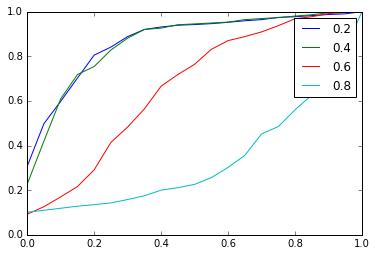

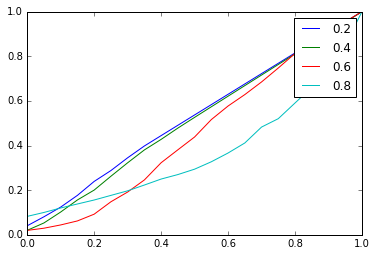

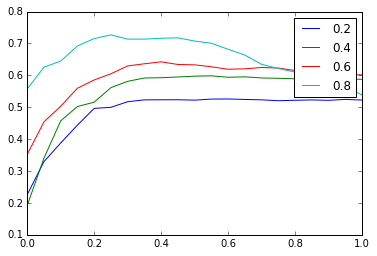

In [44]:
#max_size=max(removal_df['o'])
#o_n=[float(x)/max_size for x in removal_df.o.unique()]
o_n=[]
plt.figure()
for beta in removal_df.threshold.unique():
    #print beta
    a_f=[]
    o_n=[]
    for i in removal_df.o.unique():
        #print i*slice_size
        o_n.append(i)
        a_f.append(removal_df.loc[(removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['max_d'])

    #print a_f
    plt.plot(o_n,a_f,label=beta)

plt.legend()

plt.figure()
for beta in removal_df.threshold.unique():
    #print beta
    a_f=[]
    for i in removal_df.o.unique():
        #print i*slice_size
        a_f.append(removal_df.loc[(removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['size'])

    #print a_f
    plt.plot(o_n,a_f,label=beta)

plt.legend()

plt.figure()
for beta in removal_df.threshold.unique():
    #print beta
    a_f=[]
    for i in removal_df.o.unique():
        #print i*slice_size
        a_f.append(removal_df.loc[(removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['max_f'])

    #print a_f
    plt.plot(o_n,a_f,label=beta)

plt.legend()

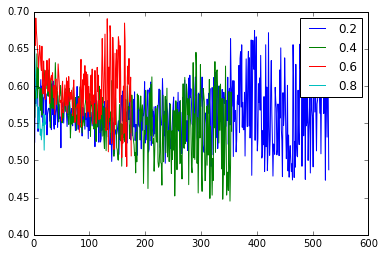

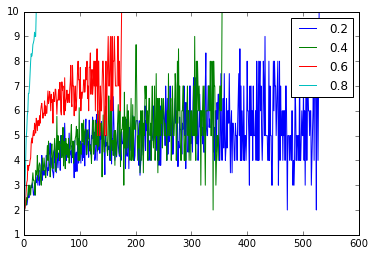

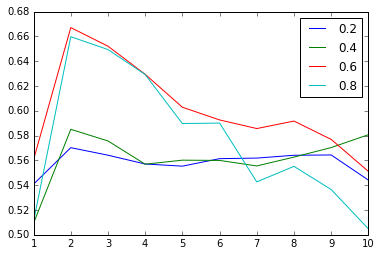

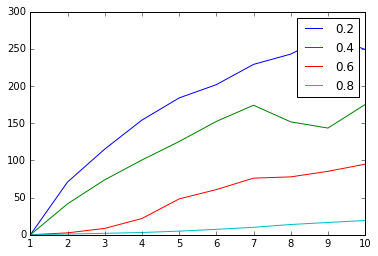

In [34]:
slices=10
max_t=df['t'].max()
slice_size=max_t/slices
x=list(xrange(slices+1))
x_n=[float(num)*slice_size for num in x]
#print x_n

plt.figure()
for beta in df.threshold.unique():
    #print beta
    a_f=[]
    x_n=[]
    #for i in x_n:
    for i in df.t.unique():
        x_n.append(i)
        #print i*slice_size
        a_f.append(df.loc[(df['t']==i) & (df['threshold']==beta)].mean()['f'])

    #print a_f
    plt.plot(x_n,a_f,label=beta)

plt.legend()

plt.figure()
for beta in df.threshold.unique():
    #print beta
    a_f=[]
    x_n=[]
    #for i in x_n:
    for i in df.t.unique():
        x_n.append(i)
        #print i*slice_size
        a_f.append(df.loc[(df['t']==i) & (df['threshold']==beta)].mean()['d'])
    #print x_n
    #print a_f
    plt.plot(x_n,a_f,label=beta)

plt.legend()

#df.boxplot(column=['d','f'],by='t')

#df.boxplot(column='f',by='t')

In [10]:
l=[0,1,2]
array=np.asarray(l)
i=array<2
print i
array[i]=0
print array


[ True  True False]
[0 0 2]


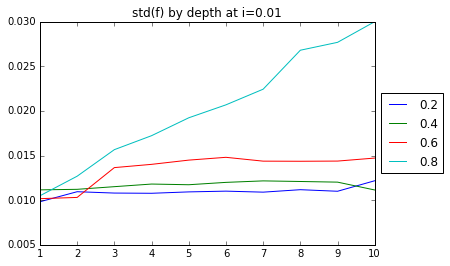

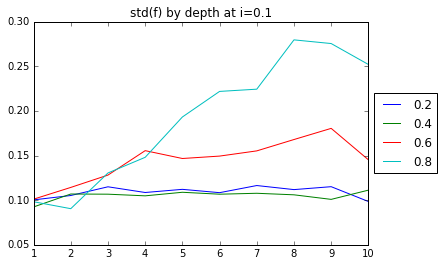

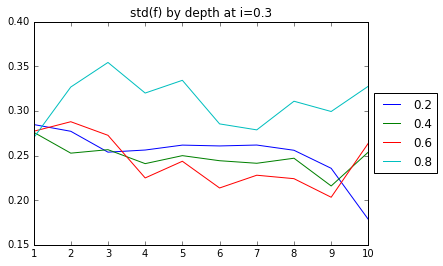

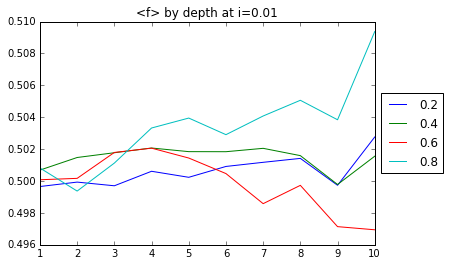

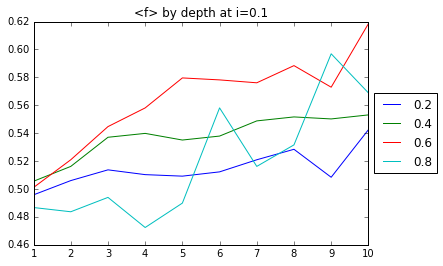

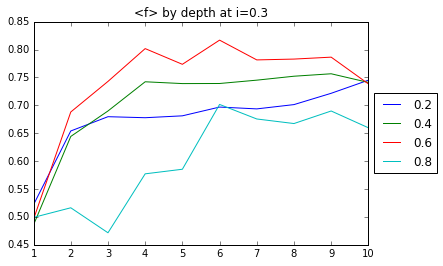

In [9]:

d_n=df.d.unique()
for inh in df.i.unique():
    plt.figure()
    plt.title('std(f) by depth at i={}'.format(inh))
    for beta in df.threshold.unique():
        #print beta
        a_f=[]
        for i in df.d.unique():
            #print i*slice_size
            a_f.append(df.loc[(df['i']==inh) & (df['d']==i) & (df['threshold']==beta)].std()['f'])

        #print a_f
        plt.plot(d_n,a_f,label=beta)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))


d_n=df.d.unique()
for inh in df.i.unique():
    plt.figure()
    plt.title('<f> by depth at i={}'.format(inh))
    for beta in df.threshold.unique():
        #print beta
        a_f=[]
        for i in df.d.unique():
            #print i*slice_size
            a_f.append(df.loc[(df['i']==inh) & (df['d']==i) & (df['threshold']==beta)].mean()['f'])

        #print a_f
        plt.plot(d_n,a_f,label=beta)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    

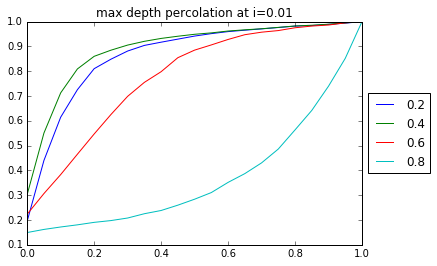

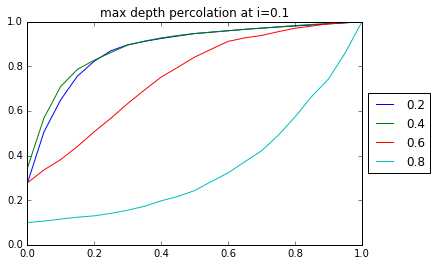

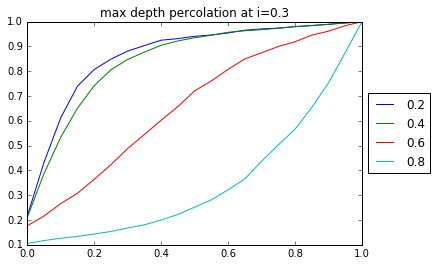

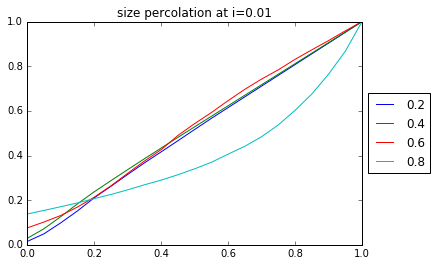

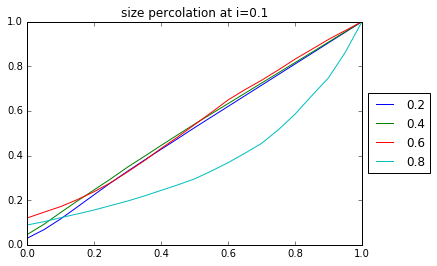

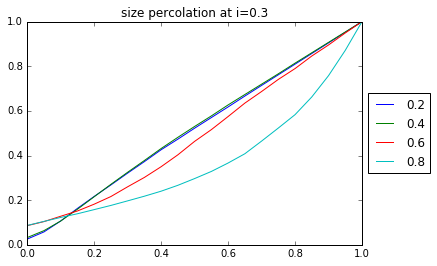

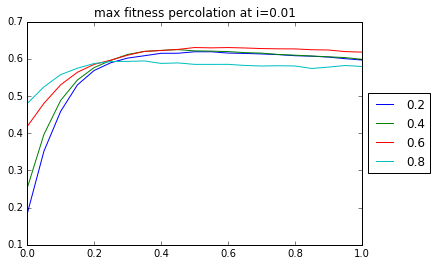

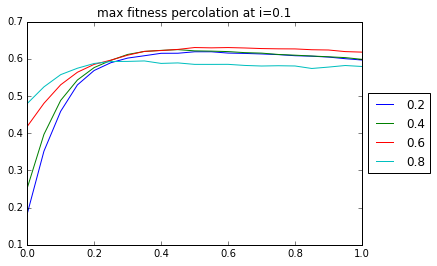

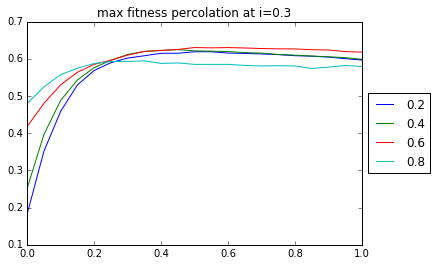

In [10]:
#max_size=max(removal_df['o'])
#o_n=[float(x)/max_size for x in removal_df.o.unique()]
o_n=[]
#plt.figure()
for inh in removal_df.i.unique():
    plt.figure()
    plt.title('max depth percolation at i={}'.format(inh))
    for beta in removal_df.threshold.unique():
        #print beta
        a_f=[]
        o_n=[]
        for i in removal_df.o.unique():
            #print i*slice_size
            o_n.append(i)
            a_f.append(removal_df.loc[(removal_df['i']==inh) & (removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['max_d'])

        #print a_f
        plt.plot(o_n,a_f,label=beta)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))

#plt.figure()
for inh in removal_df.i.unique():
    plt.figure()
    plt.title('size percolation at i={}'.format(inh))
    for beta in removal_df.threshold.unique():
        #print beta
        a_f=[]
        o_n=[]
        for i in removal_df.o.unique():
            #print i*slice_size
            o_n.append(i)
            a_f.append(removal_df.loc[(removal_df['i']==inh) & (removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['size'])

        #print a_f
        plt.plot(o_n,a_f,label=beta)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))

plt.figure()
for inh in removal_df.i.unique():
    plt.figure()
    plt.title('max fitness percolation at i={}'.format(inh))
    for beta in removal_df.threshold.unique():
        #print beta
        a_f=[]
        o_n=[]
        for i in removal_df.o.unique():
            #print i*slice_size
            o_n.append(i)
            a_f.append(removal_df.loc[(removal_df['o']==i) & (removal_df['threshold']==beta)].mean()['max_f'])

        #print a_f
        plt.plot(o_n,a_f,label=beta)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))

In [7]:
l=[10,10,5]
print l.count(10)

2


In [13]:
x=[0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,.4,.45,.5,.55]

b=[((.5-i)**2)/(1.0-i) for i in x]

print b

[0.25, 0.21315789473684213, 0.1777777777777778, 0.14411764705882352, 0.11249999999999999, 0.08333333333333333, 0.057142857142857155, 0.034615384615384624, 0.01666666666666666, 0.004545454545454543, 0.0, 0.005555555555555566]
